<div align='center'><font size="6" color="#F39C12">Getting started with Natural Language Processing</font></div>
<div align='center'><font size="5" color="#F39C12">A general Introduction</font></div>
<hr>


<p style='text-align:justify'><b>Key Objectives:</b>This notebook comes as a first part to the **Getting started with NLP Notebooks** that I am writing. This notebook explains the concepts of NLP with respect to this current competition. NLP is the field of study that focuses on the interactions between human language and computers. NLP sits at the intersection of computer science, artificial intelligence, and computational linguistics[[source](https://en.wikipedia.org/wiki/Natural_language_processing)]. NLP is a way for computers to analyze, understand, and derive meaning from human language in a smart and useful way.</p>

<b>Notebooks in this series</b>

  <ul>
      <li><a href="https://www.kaggle.com/parulpandey/getting-started-with-nlp" target="_blank">Part 1: Getting started with NLP : A General Introduction </a></li>
      <li><a href="https://www.kaggle.com/parulpandey/getting-started-with-nlp-2-countvectorizer" target="_blank">Part 2: Getting started with NLP(2)- CountVectorizer </a></li></ul>

<hr>

## Dataset
The datasets contains a set of tweets which have been divided into a training and a test set. The training set contains a target column identifying whether the tweet pertains to a real disasteror not.

Our job is to create a ML model to predict whether the test set tweets belong to a disaster or not, in the form of 1 or 0.This is a classic case of a Binary Classification problem. 

## Understanding the Evaluation Metric

Evaluation metrics are used to measure the quality of the statistical or machine learning model.There are many different types of evaluation metrics available to test a model. These include classification accuracy, logarithmic loss etc. For this particluar problem, our submissions will be evaluated using **F1** between the predicted and expected answers. 

The **F score**, also called the **F1 score** or **F measure**, is a measure of a test’s accuracy. 

The F score is defined as the weighted harmonic mean of the test’s precision and recall. 

![](https://imgur.com/nC4QwrO.png)

- Precision, also called the positive predictive value, is the proportion of positive results that truly are positive. 

- Recall, also called sensitivity, is the ability of a test to correctly identify positive results to get the true positive rate. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)
*source:https://en.wikipedia.org/wiki/Precision_and_recall*

The  F score reaches the best value, meaning perfect precision and recall, at a value of 1. The worst F score, which means lowest precision and lowest recall, would be a value of 0. 



### Why is this Useful?
The F score is used to measure a test’s accuracy, and it balances the use of precision and recall to do it. The F score can provide a more realistic measure of a test’s performance by using both precision and recall. The F score is often used in information retrieval for measuring search, document classification, and query classification performance. 
          
          
source: https://deepai.org/machine-learning-glossary-and-terms/f-score          

# Table of Contents
* [1. Importing the necessary libraries](#imports)
- [2. Reading the datasets](#reading)
- [3. Basic EDA](#eda)
- [4. Text data processing](#processing)
- [5. Transforming tokens to vectors](#vectorization)
- [6. Buiding a Text Classification model](#model)

# <a name="imports"></a>1. Importing the necessary libraries

In [2]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# <a name="reading"></a> 2. Reading the datasets

In [3]:
# List files available
print(os.listdir("../input/"))

['sample_submission.csv', 'train.csv', 'test.csv']


In [4]:
#Training data
train = pd.read_csv('../input/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data has 7613 observations and 5 features including the TARGET (the label we want to predict).

In [5]:
# Testing data 
test = pd.read_csv('../input/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Note the test data doesn't have the target column

# <a name="eda"></a> 3. Basic EDA

## Missing values

In [5]:
#Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following: 

- The `text` of a tweet
- A `keyword` from that tweet
- The `location` the tweet was sent from

In [6]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in the `location` column in both the training and the testing set.

## Exploring the Target Column

* ** Distribution of the Target Column**

We have to predict whether a given tweet is about a real disaster or not. - If so, predict a 1. If not, predict a 0.

In [6]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

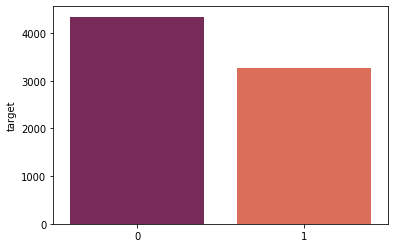

In [7]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette='rocket')

* **Exploring the Target Column**
Let's look at what the disaster and the non disaster tweets look like

In [8]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

## Exploring the 'keyword' column
The keyword column denotes a keyword from the tweet.Let's look at the top 20 keywords in the training data

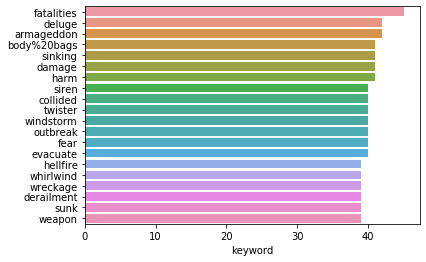

In [9]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

Let's see how often the word 'disaster' come in the dataset and whether this help us in determining whether a tweet belongs to a disaster category or not.

In [10]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

## Exploring the 'location' column
Even though the column `location` has a number of missing values, let's see the top 20 locations present in the dataset. Since some of the locations are repeated, this will require some bit of cleaning.

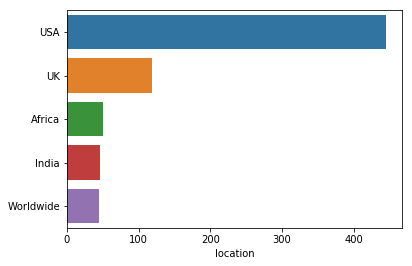

In [13]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

# <a name="processing"></a> 4. Text Data Preprocessing

## 1. Data Cleaning

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the  basic text pre-processing techniques includes:

* Make text all **lower case** or **uppercase** so that the algorithm does not treat the same words in different cases as different
* **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values,  common non-sensical text (/n)
* **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
* **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:

* **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
* **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
* Parts of speech tagging
* Create bi-grams or tri-grams
And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled : [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.Xi2BhhczZTY) that summarizes how much preprocessing you should be performing on your text data:

![](https://kavita-ganesan.com/wp-content/uploads/2019/02/Screen-Shot-2019-02-23-at-1.36.52-PM-590x270.png)

In [11]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [15]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Just for fun let's create a wordcloud of the clean text to see the most dominating words in the tweets.

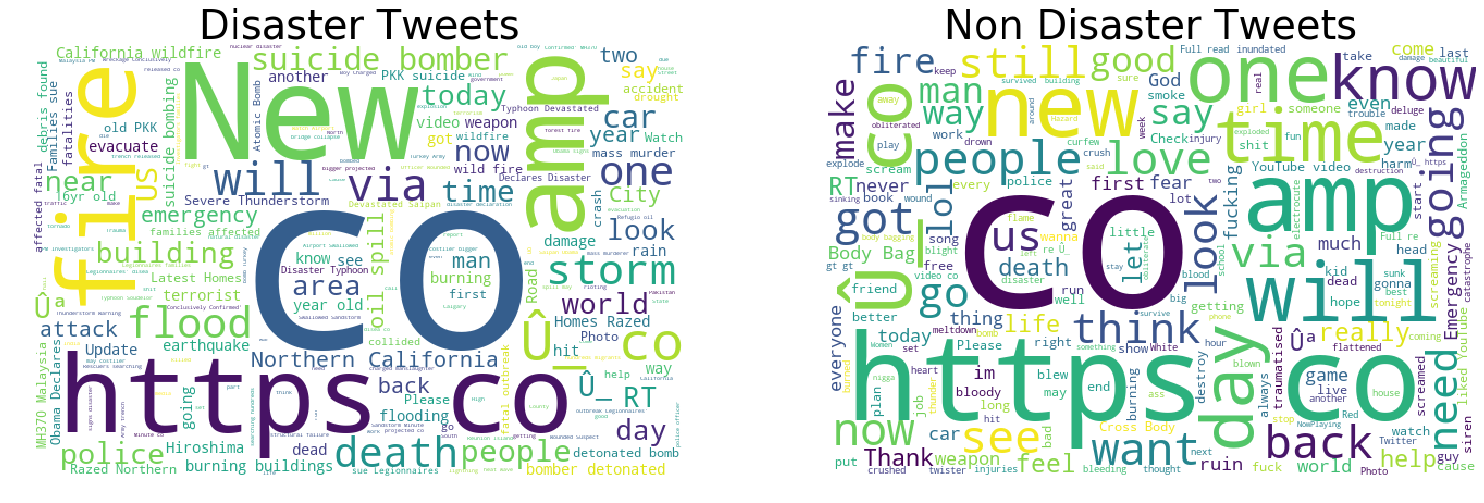

In [16]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

## 2. Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [17]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [18]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopwords Removal

Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like **a, an, the, are **etc.

In [19]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## 4. Token normalization

Token normalisation means converting different tokens to their base forms. This can be done either by:

- **Stemming** :  removing and replacing suffixes to get to the root form of the word, which is called the **stem** for instance cats - cat, wolves - wolv 
- **Lemmatization** : Returns the base or dictionary form of a word, which is known as the **lemma** 

[*source*](https://www.coursera.org/learn/language-processing/lecture/SCd4G/text-preprocessing)

In [20]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


It is important to note here that stemming and lemmatization sometimes donot necessarily improve results as at times we donot want to trim words but rather preserve their original form. Hence their usage actually differs from problem to problem. For this problem, I will not use these techniques.

In [21]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### Getting it all together- A Text Preprocessing Function
This concludes the pre-processing part. It will be prudent to convert all the steps undertaken into a function for better reusability.

In [22]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

# <a name="vectorization"></a>  5. Transforming tokens to a vector
After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. This can be done by a number of tecniques:

## Bag of Words

The bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

Why is it is called a “bag” of words? That is because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

For example, 

![](https://imgur.com/jWqtRP1.png)

*source:[Natural Language Processing course on coursera](https://www.coursera.org/learn/language-processing/home/welcome)*

We can do this using scikit-learn's CountVectorizer, where every row will represent a different tweet and every column will represent a different word.

### Bag of Words - Countvectorizer Features

[Countvectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.However, i did all the process manually above to just get a better understanding. Let's use a vanilla implementation of the countvectorizer without specifying any parameters.


In [23]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


### TFIDF Features

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

**Term Frequency: is a scoring of the frequency of the word in the current document.**

```
TF = (Number of times term t appears in a document)/(Number of terms in the document)
```

**Inverse Document Frequency: is a scoring of how rare the word is across documents.**

```
IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
```

In [24]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])


# <a name="model"></a> 6. Building a Text Classification model
Now the data is ready to be fed into a classification model. Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

## Logistic Regression Classifier

In [25]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.50301464, 0.57118787, 0.5669145 , 0.68888889])

In [26]:
clf.fit(train_vectors, train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57258065, 0.49626866, 0.54277829, 0.46618106, 0.64768683])

It appears the countvectorizer gives a better performance than TFIDF in this case.

## Naives Bayes Classifier
Well, this is a decent score. Let's try with another model that is said to work well with text data : Naive Bayes.

In [28]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63324979, 0.60688666, 0.68718683, 0.64341085, 0.72505092])

In [29]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57067603, 0.61188811, 0.5962963 , 0.7393745 ])

well the naive bayes on TFIDF features scores much better than logistic regression model. 

In [31]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## XGBoost

In [32]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.46775956, 0.384689  , 0.4330855 , 0.38900634, 0.53142857])

In [33]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores



array([0.47533632, 0.32510288, 0.42830189, 0.40084388, 0.53014354])

## Making the submission

In [34]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [35]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)